# Dane + importy

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
from dotenv import load_dotenv
from IPython.display import display
from ipywidgets import Dropdown, IntSlider, interact
from typing import Optional, Literal, Dict


# Add project root to path
project_root = Path(r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

load_dotenv(dotenv_path=project_root / ".env")
from src.utils.RepresentationModifier import RepresentationModifier


In [2]:
clip_image_scores_pt_32 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\per_timestep\clip_image_scores.csv')
clip_prompt_scores_pt_32 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\per_timestep\clip_prompt_scores.csv')
lpips_scores_pt_32 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\per_timestep\lpips_scores.csv')
nudenet_scores_pt_32 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\per_timestep\nudenet_scores.csv')

clip_image_scores_32 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\global\clip_image_scores.csv')
clip_prompt_scores_32 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\global\clip_prompt_scores.csv')
lpips_scores_32 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\global\lpips_scores.csv')
nudenet_scores_32 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\global\nudenet_scores.csv')


nudenet_scores_16 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k16\nudenet_scores.csv')
nudenet_scores_64 = pd.read_csv(r'C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k64\nudenet_scores.csv')
feature_selection_sums = torch.load("../data/analysis/merged_feature_sums.pt")

In [3]:
def prepare_nudenet_results(nudenet_scores_32: pd.DataFrame):
    results_32 = pd.DataFrame()
    for concept in nudenet_scores_32['concept'].unique():
        # Extract prompts with detected nudity for baseline (no neurons)
        baseline_df = nudenet_scores_32[nudenet_scores_32['concept'] == concept]
        baseline_df = baseline_df[(baseline_df['num_neurons'].isna()) & (baseline_df['nudity_score'] != 0.0)]
        if baseline_df.empty:
            continue  # Skip this concept

        prompt_numbers = baseline_df['prompt_number'].unique()
        baseline_avg_nudity_score = baseline_df['nudity_score'].mean()

        # Extract all rows for these prompts in certain concept
        df = nudenet_scores_32[nudenet_scores_32['concept'] == concept]
        df = df[df['prompt_number'].isin(prompt_numbers)]

        # Calculate diff in avg nudity score compared to baseline
        result = df.groupby(['concept','num_neurons', 'intervention_strength'])['nudity_score'].mean().reset_index()
        result['nudity_avg_score_diff'] = baseline_avg_nudity_score - result['nudity_score']

        # Calculate how much percentage of prompts have nudity removed (score = 0.0)
        removed_nudity = df.groupby(['concept', 'num_neurons', 'intervention_strength'])['nudity_score'].apply(lambda x: ((x == 0.0).sum() / len(x))*100).reset_index()
        removed_nudity = removed_nudity.rename(columns={'nudity_score': 'nudity_removed_percentage'})
        result = result.merge(removed_nudity, on=['concept', 'num_neurons', 'intervention_strength'])
        result = result.drop('nudity_score', axis=1)
        result["number_of_prompts"] = len(prompt_numbers)

        results_32 = pd.concat([results_32, result], ignore_index=True)
    return results_32

results_pt_32 = prepare_nudenet_results(nudenet_scores_pt_32)
results_32 = prepare_nudenet_results(nudenet_scores_32)
results_pt_64 = prepare_nudenet_results(nudenet_scores_64)  # Placeholder for 64-neuron model
results_pt_16 = prepare_nudenet_results(nudenet_scores_16)  # Placeholder for 128-neuron model

In [4]:
def combine_csv_files(dir_path: str, output_path: str = None) -> pd.DataFrame:
    """
    Combine all CSV files in a directory into a single DataFrame.
    Converts 'no_intervention' values to 0 in num_neurons and intervention_strength columns.
    
    Args:
        dir_path: Path to directory containing CSV files
        output_path: Optional path to save the combined CSV (if None, doesn't save)
    
    Returns:
        Combined DataFrame
    """
    dir_path = Path(dir_path)
    
    # Get all CSV files in the directory
    csv_files = list(dir_path.glob("*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {dir_path}")
        return None
    
    print(f"Found {len(csv_files)} CSV files")
    
    # Read and combine all CSV files
    dfs = []
    for csv_file in csv_files:
        print(f"Reading: {csv_file.name}")
        df = pd.read_csv(csv_file)
        dfs.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert 'no_intervention' to 0 for numerical columns
    if 'feature_number' in combined_df.columns:
        combined_df['feature_number'] = combined_df['feature_number'].replace('no_intervention', 0)
        combined_df['feature_number'] = pd.to_numeric(combined_df['feature_number'], errors='coerce')
    
    if 'influence_factor' in combined_df.columns:
        combined_df['influence_factor'] = combined_df['influence_factor'].replace('no_intervention', 0)
        combined_df['influence_factor'] = pd.to_numeric(combined_df['influence_factor'], errors='coerce')
    
    print(f"\nCombined DataFrame shape: {combined_df.shape}")
    print(f"Columns: {list(combined_df.columns)}")
    
    # Save if output path is provided
    if output_path:
        combined_df.to_csv(output_path, index=False)
        print(f"Saved to: {output_path}")
    
    return combined_df

# Usage example:
# fid_dir_32_pt = r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\fid_pt"
# fid_dir_32 = r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\fid"
# fid_dir_16 = r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k16\fid"
# fid_dir_64 = r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k64\fid"

fid_32_pt_output = r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\per_timestep\fid_scores.csv" 
fid_32_output = r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k32\global\fid_scores.csv"
fid_16_output = r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k16\fid_scores.csv"
fid_64_output = r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\k64\\fid_scores.csv"

# combined_fid_32_pt = combine_csv_files(fid_dir_32_pt, fid_32_pt_output)
# combined_fid_32 = combine_csv_files(fid_dir_32, fid_32_output)
# combined_fid_16 = combine_csv_files(fid_dir_16, fid_16_output)
# combined_fid_64 = combine_csv_files(fid_dir_64 , fid_64_output)

# Display the combined dataframe
# display(combined_fid_32)
### Export images from dataset to a folder

combined_fid_32_pt = pd.read_csv(fid_32_pt_output)
combined_fid_32 = pd.read_csv(fid_32_output)
combined_fid_16 = pd.read_csv(fid_16_output)
combined_fid_64 = pd.read_csv(fid_64_output)

In [15]:
def combine_fid_and_results(combined_fid: pd.DataFrame, results: pd.DataFrame, results_pt: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    """
    Combine FID scores with nudity analysis results.
    
    Args:
        combined_fid: DataFrame containing combined FID scores
        results: DataFrame containing nudity analysis results (global)
        results_pt: DataFrame containing nudity analysis results (per timestep)
    
    Returns:
        final_results: Merged DataFrame for global results
        final_results_pt: Merged DataFrame for per-timestep results
    """
    final_results_pt = combined_fid.merge(results_pt, left_on=['concept', 'feature_number', 'influence_factor'], right_on=['concept', 'num_neurons', 'intervention_strength'], how='inner')
    final_results_pt = final_results_pt.loc[final_results_pt['per_timestep'] == True]
    final_results_pt = final_results_pt[['concept', 'feature_number', 'influence_factor', 'fid_score','nudity_avg_score_diff','nudity_removed_percentage','number_of_prompts','per_timestep']]
    if results is not None:
        final_results = combined_fid.merge(results, left_on=['concept', 'feature_number', 'influence_factor'], right_on=['concept', 'num_neurons', 'intervention_strength'], how='inner')
        final_results = final_results.loc[final_results['per_timestep'] == False]
        final_results = final_results[['concept', 'feature_number', 'influence_factor', 'fid_score','nudity_avg_score_diff','nudity_removed_percentage','number_of_prompts','per_timestep']]
        return final_results, final_results_pt
    return None, final_results_pt

final_results_32, final_results_pt_32 = combine_fid_and_results(pd.concat([combined_fid_32, combined_fid_32_pt]), results_32, results_pt_32)
final_results_16, final_results_pt_16 = combine_fid_and_results(combined_fid_16, None, results_pt_16)
final_results_64, final_results_pt_64 = combine_fid_and_results(combined_fid_64, None, results_pt_64)

total_results = pd.concat([final_results_32, final_results_pt_32], ignore_index=True)

# combine all results with new column 'sae' indicating the model type
sae32_df = total_results.copy()
sae32_df['sae'] = 'sae32'
sae16_df = final_results_pt_16.copy()
sae16_df['sae'] = 'sae16'
sae64_df = final_results_pt_64.copy()
sae64_df['sae'] = 'sae64'
all_results = pd.concat([sae32_df, sae16_df, sae64_df], ignore_index=True)

## Feature selection scores analysis

In [16]:
merged_feature_sums = torch.load(r"C:\Users\jancw\Desktop\Praca Inżynierska\sd-control-and-representation\data\analysis\merged_feature_sums.pt")


means_dict_per_concept = {}
for concept in merged_feature_sums.keys():
    per_timestep_dict = {}
    for timestep,sums in merged_feature_sums[concept]['sums_per_timestep'].items():
        per_timestep_dict[timestep] = sums/merged_feature_sums[concept]['counts_per_timestep'][timestep]
    means_dict_per_concept[concept] = per_timestep_dict

mean_dict_per_concept = {}
for concept in merged_feature_sums.keys():
    sums_tensor = torch.zeros_like((merged_feature_sums[concept]['sums_per_timestep'][0]))
    counts_sum = 0
    for timestep,sums in merged_feature_sums[concept]['sums_per_timestep'].items():
        sums_tensor += sums
        counts_sum += merged_feature_sums[concept]['counts_per_timestep'][timestep]
    mean_dict_per_concept[concept] = sums_tensor / counts_sum

modifier = RepresentationModifier(
    sae=None,
    stats_dict=merged_feature_sums,
    device="cpu",
)    

In [8]:
def plot_concept_analysis(concept_name: str):
    """
    Create an interactive plot for analyzing neuron scores for a given concept.
    
    Args:
        concept_name: Name of the concept to analyze (e.g., "exposed breast")
    """
    # Calculate scores for the concept
    exposed_breast_scores = modifier.calculate_scores_for_concept(concept_name, per_timestep=True)
    total_exposed_breast_scores = modifier.calculate_scores_for_concept(concept_name, per_timestep=False)

    scores_dict = {
        timestep: exposed_breast_scores[timestep]
        for timestep in range(exposed_breast_scores.size(0))
    }

    timesteps = sorted(scores_dict.keys())

    if timesteps:
        # Use the global scores directly (total_exposed_breast_scores has shape [46080])
        # Get global top-10 indices (highest → lowest)
        _, global_top_indices = torch.topk(total_exposed_breast_scores, k=10, sorted=True)
        global_top_set = set(global_top_indices.cpu().numpy().tolist())        # for O(1) lookup
        
        # Calculate global y-axis range for all top-k scores across all timesteps
        global_y_max = 0
        global_y_min = float('inf')
    else:
        global_top_set = set()
        print("No timesteps → no global top-10 can be computed.")

    # ────────────────────────────────────────────────
    #  Plot function – now colors global top-10 bars red
    # ────────────────────────────────────────────────

    def plot_top_neurons(timestep, top_k=40, fix_y_axis=False):
        if timestep not in scores_dict:
            print(f"Timestep {timestep} not found.")
            return
        
        scores = scores_dict[timestep]
        
        # Sort descending
        sorted_values, sorted_indices = torch.sort(scores, descending=True)
        
        # Take top-k for display
        values = sorted_values[:top_k].cpu().numpy()
        indices = sorted_indices[:top_k].cpu().numpy()
        
        # Decide color per bar
        colors = []
        for idx in indices:
            if idx.item() in global_top_set:
                colors.append("rgb(220, 40, 40)")   # red for global top-10
            else:
                colors.append("rgb(60, 110, 230)")  # default blue
        
        # Hover text
        hover = [f"index: {idx}<br>score: {v:.6f}" for idx, v in zip(indices, values)]
        
        fig = go.Figure()
        
        fig.add_trace(
            go.Bar(
                x=indices.astype(str),
                y=values,
                text=[f"{v:.4f}" for v in values],
                textposition="auto",
                hovertext=hover,
                hoverinfo="text",
                marker_color=colors,
                marker_line_color="rgb(40, 40, 80)",
                marker_line_width=1.1,
                opacity=0.94
            )
        )
        
        # Calculate y-axis range if fixed
        yaxis_config = dict()
        if fix_y_axis and timesteps:
            # Get max value from top-k scores across all timesteps
            max_vals = []
            for t in timesteps:
                t_scores = scores_dict[t]
                t_sorted = torch.sort(t_scores, descending=True).values[:top_k]
                max_vals.append(t_sorted[0].item())
            
            y_max = max(max_vals)
            yaxis_config['range'] = [0, y_max * 1.05]  # Add 5% padding
        
        fig.update_layout(
            title=f"Top {top_k} neurons – '{concept_name}' – timestep {timestep}  "
                  f"(global top-10 shown in red)",
            xaxis_title="Indeks neuronu",
            yaxis_title="Wartość metryki ważności",
            xaxis=dict(
                tickangle=-45,
                tickfont=dict(size=15),
                categoryorder="array",
                categoryarray=indices.astype(str)
            ),
            yaxis=yaxis_config,
            height=540,
            width=960,
            bargap=0.22,
            template="plotly_white",
            font=dict(size=15),
            margin=dict(t=90, b=110, l=60, r=40),
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
        
        # Optional: add a minimal legend explaining the colors
        fig.add_trace(go.Bar(
            x=[None], y=[None],
            name="Global top-10 (sum)",
            marker_color="rgb(220, 40, 40)",
            showlegend=True
        ))
        fig.add_trace(go.Bar(
            x=[None], y=[None],
            name="Other",
            marker_color="rgb(60, 110, 230)",
            showlegend=True
        ))
        
        fig.show()

    # ────────────────────────────────────────────────
    #  Interactive controls (same as your guarded version)
    # ────────────────────────────────────────────────

    if not timesteps:
        print("No timesteps found in scores_dict. Please verify the dictionary contents.")
    else:
        if len(timesteps) <= 20:
            timestep_control = Dropdown(
                options=timesteps,
                value=timesteps[0],
                description="Timestep:",
                layout={"width": "max-content"}
            )
        else:
            timestep_control = IntSlider(
                min=min(timesteps),
                max=max(timesteps),
                step=1,
                value=timesteps[len(timesteps)//2],
                description="Timestep:",
                continuous_update=False,
                layout={"width": "520px"}
            )

        interact(
            plot_top_neurons,
            timestep=timestep_control,
            top_k=IntSlider(
                min=10,
                max=200,
                step=5,
                value=40,
                description="Show top:",
                continuous_update=False,
                layout={"width": "420px"}
            ),
            fix_y_axis={"False": False, "True": True}
        )

In [9]:
for concept in feature_selection_sums.keys():
    plot_concept_analysis(concept)

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

interactive(children=(IntSlider(value=25, continuous_update=False, description='Timestep:', layout=Layout(widt…

## FID Score Analysis

Lower FID score is better (indicates closer distribution to real images)

In [17]:
def plot_hyperparameter_sensitivity_nudity(df: pd.DataFrame, concept_name: str):
    """
    Analyze sensitivity to each hyperparameter separately for nudity scores.
    Shows how nudity_avg_score_diff changes when varying one hyperparameter while the other is fixed.
    
    Args:
        df: DataFrame with nudity_avg_score_diff scores (e.g., total_results)
        concept_name: Name of the concept to analyze
    """
    concept_data = df[df['concept'] == concept_name].copy()
    
    if concept_data.empty:
        print(f"No data found for concept: {concept_name}")
        return
    
    # Create subplot figure
    from plotly.subplots import make_subplots
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Feature Number Sensitivity (Per-Timestep)',
            'Feature Number Sensitivity (Global)',
            'Influence Factor Sensitivity (Per-Timestep)',
            'Influence Factor Sensitivity (Global)'
        ),
        vertical_spacing=0.15,
        horizontal_spacing=0.12
    )
    
    # Feature number sensitivity for each variant
    for col, per_timestep in enumerate([True, False], start=1):
        variant_data = concept_data[concept_data['per_timestep'] == per_timestep]
        
        # Group by feature_number and calculate statistics
        fn_grouped = variant_data.groupby('feature_number')['nudity_avg_score_diff'].agg(['mean', 'min', 'max', 'std']).reset_index()
        
        fig.add_trace(go.Scatter(
            x=fn_grouped['feature_number'],
            y=fn_grouped['mean'],
            mode='lines+markers',
            name=f"Mean ({'PT' if per_timestep else 'GL'})",
            line=dict(width=2),
            marker=dict(size=8),
            showlegend=False
        ), row=1, col=col)
        
        # Add min-max range
        fig.add_trace(go.Scatter(
            x=fn_grouped['feature_number'],
            y=fn_grouped['min'],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ), row=1, col=col)
        
        fig.add_trace(go.Scatter(
            x=fn_grouped['feature_number'],
            y=fn_grouped['max'],
            mode='lines',
            fill='tonexty',
            fillcolor='rgba(68, 68, 68, 0.2)',
            line=dict(width=0),
            name='Range',
            showlegend=False,
            hoverinfo='skip'
        ), row=1, col=col)
    
    # Influence factor sensitivity for each variant
    for col, per_timestep in enumerate([True, False], start=1):
        variant_data = concept_data[concept_data['per_timestep'] == per_timestep]
        
        # Group by influence_factor and calculate statistics
        if_grouped = variant_data.groupby('influence_factor')['nudity_avg_score_diff'].agg(['mean', 'min', 'max', 'std']).reset_index()
        
        fig.add_trace(go.Scatter(
            x=if_grouped['influence_factor'],
            y=if_grouped['mean'],
            mode='lines+markers',
            name=f"Mean ({'PT' if per_timestep else 'GL'})",
            line=dict(width=2),
            marker=dict(size=8),
            showlegend=False
        ), row=2, col=col)
        
        # Add min-max range
        fig.add_trace(go.Scatter(
            x=if_grouped['influence_factor'],
            y=if_grouped['min'],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ), row=2, col=col)
        
        fig.add_trace(go.Scatter(
            x=if_grouped['influence_factor'],
            y=if_grouped['max'],
            mode='lines',
            fill='tonexty',
            fillcolor='rgba(68, 68, 68, 0.2)',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ), row=2, col=col)
    
    # Update axes labels
    fig.update_xaxes(title_text="Feature Number", row=1, col=1)
    fig.update_xaxes(title_text="Feature Number", row=1, col=2)
    fig.update_xaxes(title_text="Influence Factor", row=2, col=1)
    fig.update_xaxes(title_text="Influence Factor", row=2, col=2)
    
    fig.update_yaxes(title_text="Nudity Avg Score Diff", row=1, col=1)
    fig.update_yaxes(title_text="Nudity Avg Score Diff", row=1, col=2)
    fig.update_yaxes(title_text="Nudity Avg Score Diff", row=2, col=1)
    fig.update_yaxes(title_text="Nudity Avg Score Diff", row=2, col=2)
    
    fig.update_layout(
        title_text=f"Hyperparameter Sensitivity Analysis (Nudity) – '{concept_name}'<br>"
                   f"<sub>Shaded area shows min-max range across different values of the other parameter</sub>",
        height=900,
        width=1200,
        template="plotly_white",
        font=dict(size=10)
    )
    
    fig.show()


# Example: Plot for one concept
if len(total_results['concept'].unique()) > 0:
    first_concept = total_results['concept'].unique()[0]
    plot_hyperparameter_sensitivity_nudity(total_results, first_concept)

In [19]:
def plot_hyperparameter_sensitivity(df: pd.DataFrame, concept_name: str):
    """
    Analyze sensitivity to each hyperparameter separately.
    Shows how FID changes when varying one hyperparameter while the other is fixed.
    
    Args:
        df: DataFrame with FID scores
        concept_name: Name of the concept to analyze
    """
    concept_data = df[df['concept'] == concept_name].copy()
    
    if concept_data.empty:
        print(f"No data found for concept: {concept_name}")
        return
    
    # Create subplot figure
    from plotly.subplots import make_subplots
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Feature Number Sensitivity (Per-Timestep)',
            'Feature Number Sensitivity (Global)',
            'Influence Factor Sensitivity (Per-Timestep)',
            'Influence Factor Sensitivity (Global)'
        ),
        vertical_spacing=0.15,
        horizontal_spacing=0.12
    )
    
    # Feature number sensitivity for each variant
    for col, per_timestep in enumerate([True, False], start=1):
        variant_data = concept_data[concept_data['per_timestep'] == per_timestep]
        
        # Group by feature_number and calculate statistics
        fn_grouped = variant_data.groupby('feature_number')['fid_score'].agg(['mean', 'min', 'max', 'std']).reset_index()
        
        fig.add_trace(go.Scatter(
            x=fn_grouped['feature_number'],
            y=fn_grouped['mean'],
            mode='lines+markers',
            name=f"Mean ({'PT' if per_timestep else 'GL'})",
            line=dict(width=2),
            marker=dict(size=8),
            showlegend=False
        ), row=1, col=col)
        
        # Add min-max range
        fig.add_trace(go.Scatter(
            x=fn_grouped['feature_number'],
            y=fn_grouped['min'],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ), row=1, col=col)
        
        fig.add_trace(go.Scatter(
            x=fn_grouped['feature_number'],
            y=fn_grouped['max'],
            mode='lines',
            fill='tonexty',
            fillcolor='rgba(68, 68, 68, 0.2)',
            line=dict(width=0),
            name='Range',
            showlegend=False,
            hoverinfo='skip'
        ), row=1, col=col)
    
    # Influence factor sensitivity for each variant
    for col, per_timestep in enumerate([True, False], start=1):
        variant_data = concept_data[concept_data['per_timestep'] == per_timestep]
        
        # Group by influence_factor and calculate statistics
        if_grouped = variant_data.groupby('influence_factor')['fid_score'].agg(['mean', 'min', 'max', 'std']).reset_index()
        
        fig.add_trace(go.Scatter(
            x=if_grouped['influence_factor'],
            y=if_grouped['mean'],
            mode='lines+markers',
            name=f"Mean ({'PT' if per_timestep else 'GL'})",
            line=dict(width=2),
            marker=dict(size=8),
            showlegend=False
        ), row=2, col=col)
        
        # Add min-max range
        fig.add_trace(go.Scatter(
            x=if_grouped['influence_factor'],
            y=if_grouped['min'],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ), row=2, col=col)
        
        fig.add_trace(go.Scatter(
            x=if_grouped['influence_factor'],
            y=if_grouped['max'],
            mode='lines',
            fill='tonexty',
            fillcolor='rgba(68, 68, 68, 0.2)',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ), row=2, col=col)
    
    # Update axes labels
    fig.update_xaxes(title_text="Feature Number", row=1, col=1)
    fig.update_xaxes(title_text="Feature Number", row=1, col=2)
    fig.update_xaxes(title_text="Influence Factor", row=2, col=1)
    fig.update_xaxes(title_text="Influence Factor", row=2, col=2)
    
    fig.update_yaxes(title_text="FID Score", row=1, col=1)
    fig.update_yaxes(title_text="FID Score", row=1, col=2)
    fig.update_yaxes(title_text="FID Score", row=2, col=1)
    fig.update_yaxes(title_text="FID Score", row=2, col=2)
    
    fig.update_layout(
        title_text=f"Hyperparameter Sensitivity Analysis – '{concept_name}'<br>"
                   f"<sub>Shaded area shows min-max range across different values of the other parameter</sub>",
        height=900,
        width=1200,
        template="plotly_white",
        font=dict(size=10)
    )
    
    fig.show()


# Example: Plot for one concept
if len(combined_fid_32['concept'].unique()) > 0:
    first_concept = combined_fid_32['concept'].unique()[0]
    plot_hyperparameter_sensitivity(pd.concat([combined_fid_32, combined_fid_32_pt]), first_concept)

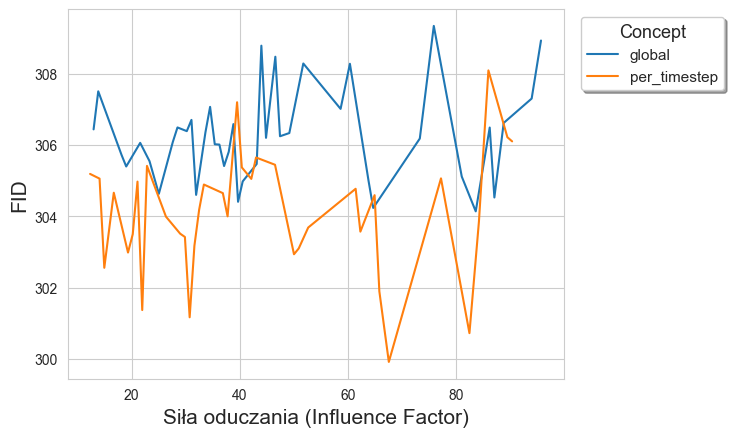

In [20]:
df = all_results.copy()
df = df[df['sae'].isin(['sae32'])]
df['group'] = df.apply(lambda row: f"{'per_timestep' if row['per_timestep'] else 'global'}", axis=1)
df['weighted_nudity_removed'] = (
    df['nudity_removed_percentage'] * df['number_of_prompts']
)
df['weighted_fid_score'] = (
    df['fid_score'] * df['number_of_prompts']
)
df_grouped = (
    df
    .groupby(['feature_number', 'influence_factor', 'group'], as_index=False)
    .agg(
        weighted_nudity_sum=('weighted_nudity_removed', 'sum'),
        weighted_fid_score_sum=('weighted_fid_score', 'sum'),
        total_prompts=('number_of_prompts', 'sum'),
    )
)

df_grouped['nudity_removed_percentage'] = (
    df_grouped['weighted_nudity_sum'] / df_grouped['total_prompts']
)
df_grouped['fid_score'] = (
    df_grouped['weighted_fid_score_sum'] / df_grouped['total_prompts']
)

# Plot
sns.set_style("whitegrid")
sns.lineplot(data=df_grouped, x='nudity_removed_percentage', y='fid_score', hue='group', errorbar=None)
plt.xlabel('Siła oduczania (Influence Factor)',fontdict={'size': 15})
plt.ylabel('FID',fontdict={'size': 15})
plt.legend(title='Concept', title_fontsize='13', fontsize='11', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, shadow=True)
plt.show()

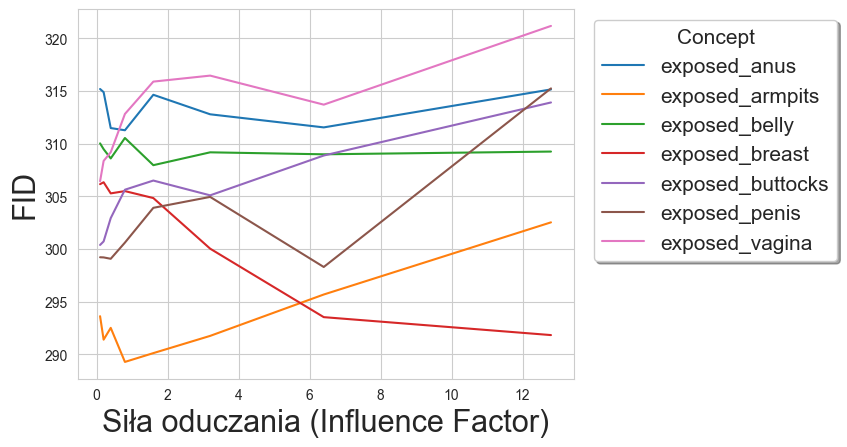

In [29]:
df = all_results.copy()

df = df[df['sae'] == 'sae32']
df = df[df['per_timestep']==True]

df['group'] = df.apply(lambda row: f"{row['concept']}", axis=1)

df['weighted_nudity_removed'] = (
    df['nudity_removed_percentage'] * df['number_of_prompts']
)
df['weighted_fid_score'] = (
    df['fid_score'] * df['number_of_prompts']
)

df_grouped = (
    df
    .groupby(['feature_number', 'influence_factor', 'group'], as_index=False)
    .agg(
        weighted_nudity_sum=('weighted_nudity_removed', 'sum'),
        weighted_fid_score_sum=('weighted_fid_score', 'sum'),
        total_prompts=('number_of_prompts', 'sum'),
    )
)

df_grouped['nudity_removed_percentage'] = (
    df_grouped['weighted_nudity_sum'] / df_grouped['total_prompts']
)
df_grouped['fid_score'] = (
    df_grouped['weighted_fid_score_sum'] / df_grouped['total_prompts']
)

# Plot
sns.set_style("whitegrid")
sns.lineplot(data=df_grouped, x='influence_factor', y='fid_score', hue='group', errorbar=None)
plt.xlabel('Siła oduczania (Influence Factor)',fontdict={'size': 22})
plt.ylabel('FID',fontdict={'size': 22})
# change position of legend to the right side
plt.legend(title='Concept', title_fontsize='15', fontsize='15', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, shadow=True)
plt.show()

## Multi-Metric Analysis

Interactive scatter plots comparing FID scores with nudity metrics

In [21]:
def plot_fid_vs_nudity_interactive(df: pd.DataFrame, baselines_df: pd.DataFrame = None):
    """
    Create an interactive scatter plot comparing FID scores with nudity metrics.
    User can select concept, which nudity metric to display, and whether to show per-timestep or global data.
    
    Args:
        df: DataFrame with columns: concept, feature_number, influence_factor, fid_score, 
            nudity_avg_score_diff, nudity_removed_percentage, per_timestep
        baselines_df: DataFrame with baseline FID scores (feature_number=0, influence_factor=0)
    """
    concepts = sorted(df['concept'].unique())
    
    def plot_scatter(concept: str, nudity_metric: str, per_timestep_filter: str):
        # Filter data based on per_timestep selection
        if per_timestep_filter == 'Per-Timestep (True)':
            filtered_df = df[df['per_timestep'] == True].copy()
            timestep_label = "Per-Timestep"
        elif per_timestep_filter == 'Global (False)':
            filtered_df = df[df['per_timestep'] == False].copy()
            timestep_label = "Global"
        else:  # 'Both'
            filtered_df = df.copy()
            timestep_label = "All Data"
        
        # Filter data for selected concept
        concept_data = filtered_df[filtered_df['concept'] == concept].copy()
        
        if concept_data.empty:
            print(f"No data found for concept: {concept} with filter: {per_timestep_filter}")
            return
        
        # Select y-axis metric
        if nudity_metric == 'nudity_avg_score_diff':
            y_data = concept_data['nudity_avg_score_diff']
            y_label = 'Średnia redukcja nagości'
            y_title = 'Średnia redukcja nagości'
        else:  # nudity_removed_percentage
            y_data = concept_data['nudity_removed_percentage']
            y_label = 'Procent usunięcia nagości (%)'
            y_title = 'Procent usunięcia nagości (%)'
        
        # Create hover text with hyperparameters
        hover_text = [
            f"Feature Number: {int(fn)}<br>"
            f"Influence Factor: {factor}<br>"
            f"FID Score: {fid:.4f}<br>"
            f"{y_label}: {y:.4f}<br>"
            f"Per-Timestep: {pt}"
            for fn, factor, fid, y, pt in zip(
                concept_data['feature_number'],
                concept_data['influence_factor'],
                concept_data['fid_score'],
                y_data,
                concept_data['per_timestep']
            )
        ]
        
        # Color by feature number - convert to categorical
        colors = concept_data['feature_number'].astype(str)
        unique_features = sorted(concept_data['feature_number'].unique())
        
        # Define discrete colorscale with Viridis colors
        import plotly.express as px
        # Sample colors from Viridis colorscale
        n_features = len(unique_features)
        viridis_colors = px.colors.sample_colorscale('Viridis', [i/(n_features-1) if n_features > 1 else 0.5 for i in range(n_features)])
        color_discrete_map = {str(int(f)): viridis_colors[i] 
                              for i, f in enumerate(unique_features)}
        
        fig = go.Figure()
        
        # Get baseline FID from baselines_df if available
        baseline_fid = None
        if baselines_df is not None:
            baseline_row = baselines_df[baselines_df['concept'] == concept]
            if not baseline_row.empty:
                baseline_fid = baseline_row['fid_score'].iloc[0]
        
        # Add vertical line for baseline FID
        if baseline_fid is not None:
            fig.add_vline(
                x=baseline_fid,
                line_dash="dash",
                line_color="red",
                line_width=2,
                annotation_text=f"Bazowy FID: {baseline_fid:.3f}",
                annotation_position="top"
            )
        
        # Add traces for each feature number (for discrete colors)
        for feature_num in unique_features:
            mask = concept_data['feature_number'] == feature_num
            feature_data = concept_data[mask]
            feature_y = y_data[mask]
            
            feature_hover_text = [
                f"Liczba cech: {int(fn)}<br>"
                f"Współczynnik wpływu: {factor}<br>"
                f"FID: {fid:.4f}<br>"
                f"{y_label}: {y:.4f}<br>"
                f"Per-Timestep: {pt}"
                for fn, factor, fid, y, pt in zip(
                    feature_data['feature_number'],
                    feature_data['influence_factor'],
                    feature_data['fid_score'],
                    feature_y,
                    feature_data['per_timestep']
                )
            ]
            
            fig.add_trace(go.Scatter(
                x=feature_data['fid_score'],
                y=feature_y,
                mode='markers',
                marker=dict(
                    size=10,
                    color=color_discrete_map[str(int(feature_num))],
                    line=dict(width=1, color='rgb(40, 40, 80)'),
                    opacity=0.8
                ),
                text=feature_hover_text,
                hoverinfo='text',
                # name= f'{int(feature_num)} cech', jezeli feature_num == 1 to '1 cecha' , w przeciwnym razie 'n cech'
                name= f"{int(feature_num)} cecha" if feature_num == 1 else (f"{int(feature_num)} cechy" if feature_num < 8 else f"{int(feature_num)} cech"),
                legendgroup=f'features_{int(feature_num)}',
                showlegend=True
            ))
        
        # Add baseline point if it exists (feature_number=0)
        baseline = concept_data[concept_data['feature_number'] == 0]
        if not baseline.empty:
            fig.add_trace(go.Scatter(
                x=baseline['fid_score'],
                y=baseline[nudity_metric],
                mode='markers',
                marker=dict(
                    size=15,
                    color='red',
                    symbol='star',
                    line=dict(width=2, color='darkred')
                ),
                name='Bazowy',
                hovertext=f"Bazowy (bez interwencji)<br>FID: {baseline['fid_score'].iloc[0]:.4f}<br>{y_label}: {baseline[nudity_metric].iloc[0]:.4f}",
                hoverinfo='text'
            ))
        
        # Calculate and add least squares regression line
        # Remove rows with NaN values
        valid_data = concept_data[['fid_score', nudity_metric]].dropna()
        if len(valid_data) > 1:  # Need at least 2 points for regression
            x_vals = valid_data['fid_score'].values
            y_vals = valid_data[nudity_metric].values
            
            # Calculate least squares fit: y = mx + b
            coefficients = np.polyfit(x_vals, y_vals, 1)
            m, b = coefficients[0], coefficients[1]
            
            # Calculate R² value
            y_pred = m * x_vals + b
            ss_res = np.sum((y_vals - y_pred) ** 2)
            ss_tot = np.sum((y_vals - np.mean(y_vals)) ** 2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            # Create regression line points
            x_range = np.array([x_vals.min(), x_vals.max()])
            y_range = m * x_range + b
            
            # Add regression line to plot
            fig.add_trace(go.Scatter(
                x=x_range,
                y=y_range,
                mode='lines',
                line=dict(
                    color='darkblue',
                    width=2,
                    dash='solid'
                ),
                name=f'Linia regresji (R²={r_squared:.3f})',
                hovertemplate=f'y = {m:.4f}x + {b:.4f}<br>R² = {r_squared:.3f}<extra></extra>',
                showlegend=True
            ))
        
        fig.update_layout(
            title=dict(
                text=f"FID vs Metryki nagości – '{concept}' ({timestep_label})<br>",
                font=dict(size=18)
            ),
            xaxis=dict(
                title=dict(
                    text="FID",
                    font=dict(size=20)
                ),
                tickfont=dict(size=14)
            ),
            yaxis=dict(
                title=dict(
                    text=y_title,
                    font=dict(size=20)
                ),
                tickfont=dict(size=14)
            ),
            height=700,
            width=1100,
            template="plotly_white",
            font=dict(size=12),
            hovermode='closest',
            legend=dict(
                yanchor="top",
                y=1.0,
                xanchor="left",
                x=1.02,
                bgcolor='rgba(255, 255, 255, 0.9)',
                bordercolor='rgba(0, 0, 0, 0.2)',
                borderwidth=1,
                font=dict(size=12)
            )
        )
        
        fig.show()

    # Create interactive controls
    concept_control = Dropdown(
        options=concepts,
        value=concepts[0],
        description="Concept:",
        layout={"width": "max-content"}
    )
    
    metric_control = Dropdown(
        options=[
            ('Nudity Avg Score Reduction', 'nudity_avg_score_diff'),
            ('Nudity Removed Percentage', 'nudity_removed_percentage')
        ],
        value='nudity_removed_percentage',
        description="Nudity Metric:",
        layout={"width": "max-content"}
    )
    
    timestep_control = Dropdown(
        options=[
            ('Per-Timestep (True)', 'Per-Timestep (True)'),
            ('Global (False)', 'Global (False)'),
            ('Both', 'Both')
        ],
        value='Per-Timestep (True)',
        description="Data Type:",
        layout={"width": "max-content"}
    )
    
    # Use interactive_output for better control
    from ipywidgets import interactive_output, VBox
    output = interactive_output(
        plot_scatter,
        {
            'concept': concept_control,
            'nudity_metric': metric_control,
            'per_timestep_filter': timestep_control
        }
    )
    
    display(VBox([concept_control, metric_control, timestep_control, output]))


# Create interactive plot using total_results which has both per_timestep True and False
# Extract baselines for the red vertical line
baselines = combined_fid_32.loc[(combined_fid_32['influence_factor'] == 0.0) & (combined_fid_32['feature_number'] == 0.0)]
plot_fid_vs_nudity_interactive(total_results, baselines_df=baselines)
# plot_fid_vs_nudity_interactive(final_results_pt_64, baselines_df=baselines)

In [22]:
def calculate_regression_statistics_simple(df: pd.DataFrame, per_timestep_value: bool = True):
    """
    Calculate least squares regression statistics (slope and R²) for per_timestep data.
    
    Args:
        df: DataFrame with columns: concept, feature_number, influence_factor, fid_score, 
            nudity_removed_percentage, per_timestep
        per_timestep_value: Filter for per_timestep True or False
    
    Returns:
        DataFrame with regression statistics (Concept, Slope, R²)
    """
    results = []
    
    # Filter for per_timestep
    filtered_df = df[df['per_timestep'] == per_timestep_value].copy()
    
    concepts = sorted(filtered_df['concept'].unique())
    metric = 'nudity_removed_percentage'
    
    for concept in concepts:
        # Filter data for selected concept
        concept_data = filtered_df[filtered_df['concept'] == concept].copy()
        
        if concept_data.empty:
            continue
        
        # Remove rows with NaN values
        valid_data = concept_data[['fid_score', metric]].dropna()
        
        if len(valid_data) > 1:  # Need at least 2 points for regression
            x_vals = valid_data['fid_score'].values
            y_vals = valid_data[metric].values
            
            # Calculate least squares fit: y = mx + b
            coefficients = np.polyfit(x_vals, y_vals, 1)
            m, b = coefficients[0], coefficients[1]
            
            # Calculate R² value
            y_pred = m * x_vals + b
            ss_res = np.sum((y_vals - y_pred) ** 2)
            ss_tot = np.sum((y_vals - np.mean(y_vals)) ** 2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            results.append({
                'Concept': concept,
                'Współczynnik nachylenia': m,
                'R²': r_squared
            })
    
    results_df = pd.DataFrame(results)
    return results_df


# Calculate and display regression statistics table for sae32, per_timestep=True
regression_stats_sae32 = calculate_regression_statistics_simple(total_results, per_timestep_value=True)
print("Statystyki regresji liniowej (SAE32, Per-Timestep=True):")
print("=" * 80)
display(regression_stats_sae32)

Statystyki regresji liniowej (SAE32, Per-Timestep=True):


,Concept,Współczynnik nachylenia,R²
0,exposed_anus,-3.046936,0.118012
1,exposed_armpits,1.050514,0.119013
2,exposed_belly,-0.054384,0.000085
3,exposed_breast,-3.679724,0.771289
4,exposed_buttocks,3.103203,0.446930
5,exposed_penis,1.378247,0.188588
6,exposed_vagina,2.082976,0.240759


In [23]:
def plot_pareto_frontier_interactive(df: pd.DataFrame):
    """
    Interactive plot of Pareto frontier showing trade-off between FID and nudity reduction.
    User can select concept, nudity metric, and whether to show per-timestep or global data.
    Points on the frontier are non-dominated (best in at least one objective).
    
    Args:
        df: DataFrame with columns including concept, feature_number, influence_factor, 
            fid_score, nudity_avg_score_diff, nudity_removed_percentage, per_timestep
    """
    concepts = sorted(df['concept'].unique())
    
    def plot_pareto(concept_name: str, nudity_metric: str, per_timestep_filter: str):
        # Filter data based on per_timestep selection
        if per_timestep_filter == 'Per-Timestep (True)':
            filtered_df = df[df['per_timestep'] == True].copy()
            timestep_label = "Per-Timestep"
        elif per_timestep_filter == 'Global (False)':
            filtered_df = df[df['per_timestep'] == False].copy()
            timestep_label = "Global"
        else:  # 'Both'
            filtered_df = df.copy()
            timestep_label = "All Data"
        
        concept_data = filtered_df[filtered_df['concept'] == concept_name].copy()
        
        if concept_data.empty:
            print(f"No data found for concept: {concept_name} with filter: {per_timestep_filter}")
            return
        
        # For Pareto: minimize FID (x), maximize nudity metric (y)
        # A point is dominated if there exists another point with both lower FID AND higher nudity
        def is_dominated(idx, data):
            point = data.loc[idx]
            for other_idx, other in data.iterrows():
                if idx == other_idx:
                    continue
                # Check if 'other' dominates 'point'
                if (other['fid_score'] <= point['fid_score'] and 
                    other[nudity_metric] >= point[nudity_metric] and
                    (other['fid_score'] < point['fid_score'] or other[nudity_metric] > point[nudity_metric])):
                    return True
            return False
        
        # Identify Pareto frontier points
        concept_data['is_pareto'] = [not is_dominated(idx, concept_data) for idx in concept_data.index]
        pareto_points = concept_data[concept_data['is_pareto']].sort_values('fid_score')
        dominated_points = concept_data[~concept_data['is_pareto']]
        
        # Create plot
        fig = go.Figure()
        
        # Plot dominated points
        if not dominated_points.empty:
            hover_dominated = [
                f"Features: {int(fn)}<br>Factor: {factor}<br>FID: {fid:.4f}<br>Nudity: {nud:.4f}<br>Per-Timestep: {pt}"
                for fn, factor, fid, nud, pt in zip(
                    dominated_points['feature_number'],
                    dominated_points['influence_factor'],
                    dominated_points['fid_score'],
                    dominated_points[nudity_metric],
                    dominated_points['per_timestep']
                )
            ]
            
            fig.add_trace(go.Scatter(
                x=dominated_points['fid_score'],
                y=dominated_points[nudity_metric],
                mode='markers',
                marker=dict(
                    size=8,
                    color='lightgray',
                    line=dict(width=1, color='gray'),
                    opacity=0.5
                ),
                name='Dominated',
                text=hover_dominated,
                hoverinfo='text'
            ))
        
        # Plot Pareto frontier points
        hover_pareto = [
            f"<b>Pareto Optimal</b><br>Features: {int(fn)}<br>Factor: {factor}<br>FID: {fid:.4f}<br>Nudity: {nud:.4f}<br>Per-Timestep: {pt}"
            for fn, factor, fid, nud, pt in zip(
                pareto_points['feature_number'],
                pareto_points['influence_factor'],
                pareto_points['fid_score'],
                pareto_points[nudity_metric],
                pareto_points['per_timestep']
            )
        ]
        
        fig.add_trace(go.Scatter(
            x=pareto_points['fid_score'],
            y=pareto_points[nudity_metric],
            mode='markers+lines',
            marker=dict(
                size=12,
                color=pareto_points['feature_number'],
                colorscale='Plasma',
                showscale=True,
                colorbar=dict(title="Feature<br>Number"),
                line=dict(width=2, color='darkblue'),
                opacity=0.9
            ),
            line=dict(color='blue', width=2, dash='dash'),
            name='Pareto Frontier',
            text=hover_pareto,
            hoverinfo='text'
        ))
        
        # Highlight baseline if exists
        baseline = concept_data[concept_data['feature_number'] == 0]
        if not baseline.empty:
            fig.add_trace(go.Scatter(
                x=baseline['fid_score'],
                y=baseline[nudity_metric],
                mode='markers',
                marker=dict(
                    size=15,
                    color='red',
                    symbol='star',
                    line=dict(width=2, color='darkred')
                ),
                name='Baseline',
                hovertext=f"Baseline<br>FID: {baseline['fid_score'].iloc[0]:.4f}<br>Nudity: {baseline[nudity_metric].iloc[0]:.4f}",
                hoverinfo='text'
            ))
        
        metric_label = 'Nudity Removed (%)' if nudity_metric == 'nudity_removed_percentage' else 'Nudity Score Reduction'
        
        fig.update_layout(
            title=f"Pareto Frontier – '{concept_name}' ({timestep_label})<br>"
                  f"<sub>Blue line shows non-dominated configurations (optimal trade-offs)</sub>",
            xaxis_title="FID Score (minimize ←)",
            yaxis_title=f"{metric_label} (maximize →)",
            height=700,
            width=1000,
            template="plotly_white",
            font=dict(size=11),
            hovermode='closest'
        )
        
        fig.show()
        
        print(f"\nPareto Frontier Analysis for '{concept_name}' ({timestep_label}):")
        print("=" * 80)
        print(f"Total configurations: {len(concept_data)}")
        print(f"Pareto optimal configurations: {len(pareto_points)}")
        print(f"\nPareto Optimal Points (sorted by FID):")
        print(pareto_points[['feature_number', 'influence_factor', 'fid_score', nudity_metric]].to_string(index=False))
    
    # Create interactive controls
    concept_control = Dropdown(
        options=concepts,
        value=concepts[0],
        description="Concept:",
        layout={"width": "max-content"}
    )
    
    metric_control = Dropdown(
        options=[
            ('Nudity Avg Score Reduction', 'nudity_avg_score_diff'),
            ('Nudity Removed Percentage', 'nudity_removed_percentage')
        ],
        value='nudity_avg_score_diff',
        description="Nudity Metric:",
        layout={"width": "max-content"}
    )
    
    timestep_control = Dropdown(
        options=[
            ('Per-Timestep (True)', 'Per-Timestep (True)'),
            ('Global (False)', 'Global (False)'),
            ('Both', 'Both')
        ],
        value='Per-Timestep (True)',
        description="Data Type:",
        layout={"width": "max-content"}
    )
    
    interact(
        plot_pareto,
        concept_name=concept_control,
        nudity_metric=metric_control,
        per_timestep_filter=timestep_control
    )


# Plot interactive Pareto frontiers
plot_pareto_frontier_interactive(total_results)

interactive(children=(Dropdown(description='Concept:', layout=Layout(width='max-content'), options=('exposed_a…

In [24]:
def plot_fid_vs_nudity_interactive_case1(df: pd.DataFrame, baselines_df: pd.DataFrame = None, 
                                          highlight_column: str = None, highlight_value = None):
    """
    Create an interactive scatter plot comparing FID scores with nudity metrics.
    User can select concept, which nudity metric to display, and whether to show per-timestep or global data.
    
    Args:
        df: DataFrame with columns: concept, feature_number, influence_factor, fid_score, 
            nudity_avg_score_diff, nudity_removed_percentage, per_timestep
        baselines_df: DataFrame with baseline FID scores (feature_number=0, influence_factor=0)
        highlight_column: Column name to filter for highlighting (e.g., 'feature_number')
        highlight_value: Value in the highlight_column to color red (e.g., 6)
    """
    concepts = sorted(df['concept'].unique())
    
    def plot_scatter(concept: str, nudity_metric: str, per_timestep_filter: str):
        # Filter data based on per_timestep selection
        if per_timestep_filter == 'Per-Timestep (True)':
            filtered_df = df[df['per_timestep'] == True].copy()
            timestep_label = "Per-Timestep"
        elif per_timestep_filter == 'Global (False)':
            filtered_df = df[df['per_timestep'] == False].copy()
            timestep_label = "Global"
        else:  # 'Both'
            filtered_df = df.copy()
            timestep_label = "All Data"
        
        # Filter data for selected concept
        concept_data = filtered_df[filtered_df['concept'] == concept].copy()
        
        if concept_data.empty:
            print(f"No data found for concept: {concept} with filter: {per_timestep_filter}")
            return
        
        # Select y-axis metric
        if nudity_metric == 'nudity_avg_score_diff':
            y_data = concept_data['nudity_avg_score_diff']
            y_label = 'Nudity Avg Score Reduction'
            y_title = 'Average Nudity Score Reduction (higher is better)'
        else:  # nudity_removed_percentage
            y_data = concept_data['nudity_removed_percentage']
            y_label = 'Nudity Removed %'
            y_title = 'Percentage of Images with Nudity Removed (higher is better)'
        
        # Create hover text with hyperparameters
        hover_text = [
            f"Feature Number: {int(fn)}<br>"
            f"Influence Factor: {factor}<br>"
            f"FID Score: {fid:.4f}<br>"
            f"{y_label}: {y:.4f}<br>"
            f"Per-Timestep: {pt}"
            for fn, factor, fid, y, pt in zip(
                concept_data['feature_number'],
                concept_data['influence_factor'],
                concept_data['fid_score'],
                y_data,
                concept_data['per_timestep']
            )
        ]
        
        # Determine which points to highlight
        if highlight_column is not None and highlight_value is not None and highlight_column in concept_data.columns:
            # Create mask for highlighted points
            highlight_mask = concept_data[highlight_column] == highlight_value
            highlighted_data = concept_data[highlight_mask]
            non_highlighted_data = concept_data[~highlight_mask]
            
            # Split hover text accordingly
            highlighted_hover = [hover_text[i] for i, mask in enumerate(highlight_mask) if mask]
            non_highlighted_hover = [hover_text[i] for i, mask in enumerate(highlight_mask) if not mask]
        else:
            # No highlighting, all points default color
            highlighted_data = pd.DataFrame()
            non_highlighted_data = concept_data
            highlighted_hover = []
            non_highlighted_hover = hover_text
        
        fig = go.Figure()
        
        # Get baseline FID from baselines_df if available
        baseline_fid = None
        if baselines_df is not None:
            baseline_row = baselines_df[baselines_df['concept'] == concept]
            if not baseline_row.empty:
                baseline_fid = baseline_row['fid_score'].iloc[0]
        
        # Add vertical line for baseline FID
        if baseline_fid is not None:
            fig.add_vline(
                x=baseline_fid,
                line_dash="dash",
                line_color="red",
                line_width=2,
                annotation_text=f"Baseline FID: {baseline_fid:.3f}",
                annotation_position="top"
            )
        
        # Add non-highlighted points (default color)
        if not non_highlighted_data.empty:
            fig.add_trace(go.Scatter(
                x=non_highlighted_data['fid_score'],
                y=non_highlighted_data[nudity_metric] if nudity_metric in non_highlighted_data.columns else 
                  (non_highlighted_data['nudity_avg_score_diff'] if nudity_metric == 'nudity_avg_score_diff' else non_highlighted_data['nudity_removed_percentage']),
                mode='markers',
                marker=dict(
                    size=10,
                    color='blue',
                    line=dict(width=1, color='rgb(40, 40, 80)'),
                    opacity=0.6
                ),
                text=non_highlighted_hover,
                hoverinfo='text',
                name='Other points'
            ))
        
        # Add highlighted points (red color)
        if not highlighted_data.empty:
            fig.add_trace(go.Scatter(
                x=highlighted_data['fid_score'],
                y=highlighted_data[nudity_metric] if nudity_metric in highlighted_data.columns else 
                  (highlighted_data['nudity_avg_score_diff'] if nudity_metric == 'nudity_avg_score_diff' else highlighted_data['nudity_removed_percentage']),
                mode='markers',
                marker=dict(
                    size=10,
                    color='red',
                    line=dict(width=1, color='darkred'),
                    opacity=0.8
                ),
                text=highlighted_hover,
                hoverinfo='text',
                name=f'{highlight_column}={highlight_value}'
            ))
        
        # Add baseline point if it exists (feature_number=0)
        baseline = concept_data[concept_data['feature_number'] == 0]
        if not baseline.empty:
            fig.add_trace(go.Scatter(
                x=baseline['fid_score'],
                y=baseline[nudity_metric],
                mode='markers',
                marker=dict(
                    size=15,
                    color='orange',
                    symbol='star',
                    line=dict(width=2, color='darkorange')
                ),
                name='Baseline',
                hovertext=f"Baseline (no intervention)<br>FID: {baseline['fid_score'].iloc[0]:.4f}<br>{y_label}: {baseline[nudity_metric].iloc[0]:.4f}",
                hoverinfo='text'
            ))
        
        # Find best point (lowest FID, highest nudity reduction)
        # We want to maximize both nudity metric and minimize FID
        # Let's find the point with best combined score (normalized)
        normalized_fid = (concept_data['fid_score'] - concept_data['fid_score'].min()) / (concept_data['fid_score'].max() - concept_data['fid_score'].min() + 1e-10)
        normalized_nudity = (y_data - y_data.min()) / (y_data.max() - y_data.min() + 1e-10)
        combined_score = normalized_nudity - normalized_fid  # Higher nudity reduction, lower FID
        best_idx = combined_score.idxmax()
        best_point = concept_data.loc[best_idx]
        
        fig.add_trace(go.Scatter(
            x=[best_point['fid_score']],
            y=[best_point[nudity_metric]],
            mode='markers',
            marker=dict(
                size=15,
                color='green',
                symbol='diamond',
                line=dict(width=2, color='darkgreen')
            ),
            name='Best Combined',
            hovertext=f"Best Combined Score<br>Features: {int(best_point['feature_number'])}<br>Factor: {best_point['influence_factor']}<br>FID: {best_point['fid_score']:.4f}<br>{y_label}: {best_point[nudity_metric]:.4f}",
            hoverinfo='text'
        ))
        
        # Update title to mention highlighting if active
        title_suffix = ""
        if highlight_column is not None and highlight_value is not None:
            title_suffix = f"<br><sub>Red points: {highlight_column}={highlight_value}</sub>"
        
        fig.update_layout(
            title=f"FID vs Nudity Metrics – '{concept}' ({timestep_label})<br>"
                  f"<sub>Hover for hyperparameters.</sub>{title_suffix}",
            xaxis_title="FID Score (lower is better)",
            yaxis_title=y_title,
            height=700,
            width=1000,
            template="plotly_white",
            font=dict(size=11),
            hovermode='closest',
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="left",
                x=0.01,
                bgcolor='rgba(255, 255, 255, 0.8)'
            )
        )
        
        fig.show()
        
        # Print summary statistics
        print(f"\nSummary for '{concept}' ({timestep_label}):")
        print("=" * 70)
        print(f"FID Score - Min: {concept_data['fid_score'].min():.4f}, Max: {concept_data['fid_score'].max():.4f}")
        print(f"{y_label} - Min: {y_data.min():.4f}, Max: {y_data.max():.4f}")
        print(f"\nBest Combined Configuration:")
        print(f"  Feature Number: {int(best_point['feature_number'])}")
        print(f"  Influence Factor: {best_point['influence_factor']}")
        print(f"  FID Score: {best_point['fid_score']:.4f}")
        print(f"  {y_label}: {best_point[nudity_metric]:.4f}")
        
        if highlight_column is not None and highlight_value is not None and not highlighted_data.empty:
            print(f"\nHighlighted points ({highlight_column}={highlight_value}): {len(highlighted_data)}")
    
    # Create interactive controls
    concept_control = Dropdown(
        options=concepts,
        value=concepts[0],
        description="Concept:",
        layout={"width": "max-content"}
    )
    
    metric_control = Dropdown(
        options=[
            ('Nudity Avg Score Reduction', 'nudity_avg_score_diff'),
            ('Nudity Removed Percentage', 'nudity_removed_percentage')
        ],
        value='nudity_removed_percentage',
        description="Nudity Metric:",
        layout={"width": "max-content"}
    )
    
    timestep_control = Dropdown(
        options=[
            ('Per-Timestep (True)', 'Per-Timestep (True)'),
            ('Global (False)', 'Global (False)'),
            ('Both', 'Both')
        ],
        value='Per-Timestep (True)',
        description="Data Type:",
        layout={"width": "max-content"}
    )
    
    # Use interactive_output for better control
    from ipywidgets import interactive_output, VBox
    output = interactive_output(
        plot_scatter,
        {
            'concept': concept_control,
            'nudity_metric': metric_control,
            'per_timestep_filter': timestep_control
        }
    )
    
    display(VBox([concept_control, metric_control, timestep_control, output]))


# Create interactive plot using total_results which has both per_timestep True and False
# Extract baselines for the red vertical line
baselines = combined_fid_32.loc[(combined_fid_32['influence_factor'] == 0.0) & (combined_fid_32['feature_number'] == 0.0)]
# plot_fid_vs_nudity_interactive(total_results, baselines_df=baselines)
# plot_fid_vs_nudity_interactive(final_results_pt_16, baselines_df=baselines)
# plot_fid_vs_nudity_interactive(final_results_pt_64, baselines_df=baselines)
plot_fid_vs_nudity_interactive_case1(
    total_results, 
    baselines_df=baselines,
    highlight_column='influence_factor',
    highlight_value=12.8
)


## FID Distribution Analysis - Per-Timestep vs Global

Compare FID score distributions between the two intervention methods

In [84]:
def plot_fid_distribution_comparison(df: pd.DataFrame, concept_name: str):
    """
    Plot overlapping histograms comparing FID distributions between per-timestep and global variants.
    
    Args:
        df: DataFrame with columns: concept, fid_score, per_timestep
        concept_name: Name of the concept to plot
    """
    concept_data = df[df['concept'] == concept_name].copy()
    
    if concept_data.empty:
        print(f"No data found for concept: {concept_name}")
        return
    
    # Split data by variant
    pt_data = concept_data[concept_data['per_timestep'] == True]['fid_score']
    gl_data = concept_data[concept_data['per_timestep'] == False]['fid_score']
    
    # Create figure
    fig = go.Figure()
    
    # Add histogram for Per-Timestep
    if not pt_data.empty:
        fig.add_trace(go.Histogram(
            x=pt_data,
            name='Per-Timestep',
            opacity=0.7,
            marker_color='rgb(55, 83, 109)',
            nbinsx=30,
            histnorm='probability density'
        ))
    
    # Add histogram for Global
    if not gl_data.empty:
        fig.add_trace(go.Histogram(
            x=gl_data,
            name='Global',
            opacity=0.7,
            marker_color='rgb(26, 118, 255)',
            nbinsx=30,
            histnorm='probability density'
        ))
    
    # Calculate statistics
    pt_stats = {
        'mean': pt_data.mean() if not pt_data.empty else None,
        'median': pt_data.median() if not pt_data.empty else None,
        'std': pt_data.std() if not pt_data.empty else None,
        'min': pt_data.min() if not pt_data.empty else None,
        'max': pt_data.max() if not pt_data.empty else None
    }
    
    gl_stats = {
        'mean': gl_data.mean() if not gl_data.empty else None,
        'median': gl_data.median() if not gl_data.empty else None,
        'std': gl_data.std() if not gl_data.empty else None,
        'min': gl_data.min() if not gl_data.empty else None,
        'max': gl_data.max() if not gl_data.empty else None
    }
    
    # Add vertical lines for means
    if pt_stats['mean'] is not None:
        fig.add_vline(
            x=pt_stats['mean'],
            line_dash="dash",
            line_color="rgb(55, 83, 109)",
            line_width=2,
            annotation_text=f"PT Mean: {pt_stats['mean']:.3f}",
            annotation_position="top left"
        )
    
    if gl_stats['mean'] is not None:
        fig.add_vline(
            x=gl_stats['mean'],
            line_dash="dash",
            line_color="rgb(26, 118, 255)",
            line_width=2,
            annotation_text=f"GL Mean: {gl_stats['mean']:.3f}",
            annotation_position="top right"
        )
    
    fig.update_layout(
        title=f"FID Score Distribution – '{concept_name}'<br>"
              f"<sub>Per-Timestep vs Global intervention methods</sub>",
        xaxis_title="FID Score",
        yaxis_title="Probability Density",
        barmode='overlay',
        height=600,
        width=1000,
        template="plotly_white",
        font=dict(size=11),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    
    fig.show()
    
    # Print statistics
    print(f"\nFID Distribution Statistics for '{concept_name}':")
    print("=" * 80)
    print(f"\nPer-Timestep (n={len(pt_data)}):")
    print(f"  Mean: {pt_stats['mean']:.4f}")
    print(f"  Median: {pt_stats['median']:.4f}")
    print(f"  Std Dev: {pt_stats['std']:.4f}")
    print(f"  Range: [{pt_stats['min']:.4f}, {pt_stats['max']:.4f}]")
    
    print(f"\nGlobal (n={len(gl_data)}):")
    print(f"  Mean: {gl_stats['mean']:.4f}")
    print(f"  Median: {gl_stats['median']:.4f}")
    print(f"  Std Dev: {gl_stats['std']:.4f}")
    print(f"  Range: [{gl_stats['min']:.4f}, {gl_stats['max']:.4f}]")
    
    # Calculate difference
    mean_diff = pt_stats['mean'] - gl_stats['mean']
    print(f"\nDifference (Per-Timestep - Global):")
    print(f"  Mean difference: {mean_diff:.4f}")
    print(f"  Percentage difference: {(mean_diff/gl_stats['mean']*100):.2f}%")
    
    # Perform statistical test if scipy is available
    try:
        from scipy import stats
        # Perform Mann-Whitney U test (non-parametric)
        statistic, p_value = stats.mannwhitneyu(pt_data, gl_data, alternative='two-sided')
        print(f"\nMann-Whitney U Test:")
        print(f"  Statistic: {statistic:.4f}")
        print(f"  P-value: {p_value:.6f}")
        if p_value < 0.05:
            print(f"  → Distributions are significantly different (p < 0.05)")
        else:
            print(f"  → No significant difference found (p >= 0.05)")
    except ImportError:
        print("\n(Install scipy for statistical significance testing)")


def plot_all_fid_distributions(df: pd.DataFrame):
    """
    Plot FID distributions for all concepts.
    
    Args:
        df: DataFrame with FID scores
    """
    concepts = sorted(df['concept'].unique())
    
    for concept in concepts:
        plot_fid_distribution_comparison(df, concept)

total_results_2 = total_results.loc[total_results['concept'] != 'exposed_armpits']
total_results_2 = total_results_2.loc[total_results_2['concept'] != 'exposed_feet']

# Plot FID distributions for all concepts
plot_all_fid_distributions(total_results_2)


FID Distribution Statistics for 'exposed_anus':

Per-Timestep (n=48):
  Mean: 313.3641
  Median: 314.6586
  Std Dev: 4.1861
  Range: [304.8551, 321.4803]

Global (n=48):
  Mean: 314.4039
  Median: 313.3816
  Std Dev: 7.0840
  Range: [301.0834, 338.5071]

Difference (Per-Timestep - Global):
  Mean difference: -1.0397
  Percentage difference: -0.33%

Mann-Whitney U Test:
  Statistic: 1155.0000
  P-value: 0.985384
  → No significant difference found (p >= 0.05)



FID Distribution Statistics for 'exposed_belly':

Per-Timestep (n=48):
  Mean: 309.2494
  Median: 309.5884
  Std Dev: 3.7903
  Range: [295.7768, 319.9666]

Global (n=48):
  Mean: 308.1260
  Median: 307.2281
  Std Dev: 3.1420
  Range: [303.0092, 316.8216]

Difference (Per-Timestep - Global):
  Mean difference: 1.1234
  Percentage difference: 0.36%

Mann-Whitney U Test:
  Statistic: 1468.0000
  P-value: 0.020785
  → Distributions are significantly different (p < 0.05)



FID Distribution Statistics for 'exposed_breast':

Per-Timestep (n=48):
  Mean: 301.6889
  Median: 304.1244
  Std Dev: 7.1638
  Range: [283.8192, 313.6564]

Global (n=48):
  Mean: 302.4565
  Median: 305.3826
  Std Dev: 7.3198
  Range: [282.5869, 309.8918]

Difference (Per-Timestep - Global):
  Mean difference: -0.7676
  Percentage difference: -0.25%

Mann-Whitney U Test:
  Statistic: 978.0000
  P-value: 0.203606
  → No significant difference found (p >= 0.05)



FID Distribution Statistics for 'exposed_buttocks':

Per-Timestep (n=48):
  Mean: 305.5045
  Median: 304.2565
  Std Dev: 5.9168
  Range: [296.4569, 327.0223]

Global (n=48):
  Mean: 303.3298
  Median: 301.3367
  Std Dev: 5.8287
  Range: [296.4668, 319.8740]

Difference (Per-Timestep - Global):
  Mean difference: 2.1747
  Percentage difference: 0.72%

Mann-Whitney U Test:
  Statistic: 1468.0000
  P-value: 0.020785
  → Distributions are significantly different (p < 0.05)



FID Distribution Statistics for 'exposed_penis':

Per-Timestep (n=48):
  Mean: 302.5626
  Median: 300.1280
  Std Dev: 7.1297
  Range: [294.4046, 328.3603]

Global (n=48):
  Mean: 303.1199
  Median: 301.7507
  Std Dev: 6.5094
  Range: [296.0890, 327.7183]

Difference (Per-Timestep - Global):
  Mean difference: -0.5573
  Percentage difference: -0.18%

Mann-Whitney U Test:
  Statistic: 987.0000
  P-value: 0.228051
  → No significant difference found (p >= 0.05)



FID Distribution Statistics for 'exposed_vagina':

Per-Timestep (n=48):
  Mean: 312.9994
  Median: 311.5408
  Std Dev: 6.7593
  Range: [302.2643, 327.9454]

Global (n=48):
  Mean: 312.7348
  Median: 311.4074
  Std Dev: 7.8448
  Range: [300.7351, 337.4520]

Difference (Per-Timestep - Global):
  Mean difference: 0.2646
  Percentage difference: 0.08%

Mann-Whitney U Test:
  Statistic: 1202.0000
  P-value: 0.716816
  → No significant difference found (p >= 0.05)
